# 导入相关库
# CNN + RNN 模型
# 使用Spectrogram

In [1]:
import pandas as pd
import os
import pathlib
import glob
import matplotlib. pyplot as plt
import numpy as np
import seaborn as sns
import librosa
from concurrent.futures import ThreadPoolExecutor
import sklearn as sk 
import scipy
from sklearn import preprocessing
from sklearn import model_selection


## 构建数据集

In [2]:
data_dir = pathlib.Path('speech_commands_v0.02/')

fileset =[file for file in glob.glob(str(data_dir)+ "**/**/*.wav", recursive=True)]

In [3]:
len(fileset)

26903

In [4]:
dataset = pd.DataFrame(fileset, columns=['path'])

In [5]:
dataset['command']=dataset['path'].apply(lambda x:os. path.basename(os.path.dirname(x)))

In [6]:
dataset.head()

,path,command
0,speech_commands_v0.02\go\004ae714_nohash_0.wav,go
1,speech_commands_v0.02\go\004ae714_nohash_1.wav,go
2,speech_commands_v0.02\go\00970ce1_nohash_0.wav,go
3,speech_commands_v0.02\go\00b01445_nohash_0.wav,go
4,speech_commands_v0.02\go\00f0204f_nohash_0.wav,go


In [7]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate /1e3)) # 窗口中采样点的个数
    noverlap = int(round(step_size * sample_rate /1e3))
    freqs, times, spec = scipy.signal.spectrogram(audio, fs=sample_rate, window='hann', nperseg=nperseg, noverlap=noverlap, detrend=False)

    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
#查看scipy, io读取的数据和librosa的区别
from scipy.io import wavfile
import scipy.io

sample_rate, signal= scipy.io.wavfile.read(dataset.loc[1,'path'])

print(signal)
print(sample_rate)
print(f"音频长度：{signal.shape}", signal.dtype)

s, sr = librosa.load(dataset.loc[1,'path'], sr=16000)

print(s)
print(sample_rate)
print (f"音频长度：{s.shape}", s.dtype)

[ -78 -125 -110 ... -287  -65 -201]
16000
音频长度：(11146,) int16
[-0.00238037 -0.0038147  -0.00335693 ... -0.00875854 -0.00198364
 -0.00613403]
16000
音频长度：(11146,) float32


In [9]:
def get_specgram(file_path):
    sample_rate, signal = scipy.io.wavfile.read(file_path)
    signal_padding = np.zeros((16000,))
    #统一输入音频文件长度，当音频文件大于1秒时切尾，当音频长度小于1秒时补零signal_padding np. zeros((16000,))
    if len(signal)>=16000:
        signal_padding = signal[:16000]
    else:
        signal_padding[:len(signal)] = signal
    
    #获取频谱
    _, _, specgram = log_specgram(signal_padding, sample_rate=sample_rate) 
    return specgram

In [10]:
file_path_check = dataset.loc[80,'path']

file_path_check

'speech_commands_v0.02\\go\\05b2db80_nohash_0.wav'

In [11]:
spec_check = get_specgram(file_path_check)

spec_check.shape ##(data, time) 适配RNN

(99, 161)

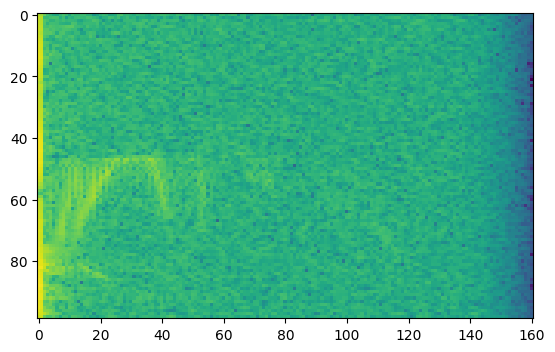

In [12]:
plt.imshow(spec_check)

In [13]:
dataset['spec'] = dataset['path'].apply(lambda x: get_specgram(x))

C:\Users\hawcat\AppData\Local\Temp\ipykernel_42044\2824997324.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = scipy.io.wavfile.read(file_path)


In [14]:
dataset.head()

,path,command,spec
0,speech_commands_v0.02\go\004ae714_nohash_0.wav,go,"[[4.58502, 4.145232, -0.007151785, -6.453975, ..."
1,speech_commands_v0.02\go\004ae714_nohash_1.wav,go,"[[5.2127824, 4.648273, -0.4192507, -0.8653413,..."
2,speech_commands_v0.02\go\00970ce1_nohash_0.wav,go,"[[2.1306756, 2.3093808, 0.55220026, -1.2955396..."
3,speech_commands_v0.02\go\00b01445_nohash_0.wav,go,"[[-8.011622, -9.299327, -2.662695, -1.2273933,..."
4,speech_commands_v0.02\go\00f0204f_nohash_0.wav,go,"[[-1.4270273, 0.29149553, 1.5646031, 1.787156,..."


In [15]:
le = preprocessing.LabelEncoder()
dataset['cmd_value'] = le.fit_transform(dataset['command'])

In [16]:
dataset.tail()

,path,command,spec,cmd_value
26898,speech_commands_v0.02\_background_noise_\dude_...,_background_noise_,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0
26899,speech_commands_v0.02\_background_noise_\exerc...,_background_noise_,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0
26900,speech_commands_v0.02\_background_noise_\pink_...,_background_noise_,"[[15.163007, 14.838174, 13.193706, 12.08154, 1...",0
26901,speech_commands_v0.02\_background_noise_\runni...,_background_noise_,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0
26902,speech_commands_v0.02\_background_noise_\white...,_background_noise_,"[[6.37398, 7.8804846, 10.268957, 10.408761, 7....",0


In [17]:
le.classes_

array(['_background_noise_', 'go', 'max', 'no', 'off', 'on', 'stop',
       'wow'], dtype=object)

## 模型部分

In [18]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, LSTM
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
input_dim= (99, 161)
output_dim = len(le.classes_)
dropout =0.2

input_data = Input(shape=input_dim)

x=Conv1D(filters=256, kernel_size=10, strides=4)(input_data)
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(dropout)(x)

x=LSTM(128, activation='relu', return_sequences=True, dropout=dropout)(x)
x=LSTM(128, activation='relu', return_sequences=False, dropout=dropout)(x)

x=Dense(units=64, activation='relu')(x)
x=Dropout(dropout)(x)

output_data = Dense(output_dim, activation='softmax')(x)

K.clear_session
model = Model(inputs=input_data, outputs=output_data)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 99, 161)]         0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           412416    
                                                                 
 batch_normalization (BatchN  (None, 23, 256)          1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 256)           0         
                                                                 
 dropout (Dropout)           (None, 23, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 23, 128)           197120    
                                                             

In [20]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard

sgd = SGD(learning_rate=0.00001, clipnorm=1.0)
adam = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [21]:
X = np.array([i for i in dataset['spec']])

In [22]:
X.shape

(26903, 99, 161)

In [23]:
y = np.array(dataset['cmd_value'])

In [24]:
y.shape

(26903,)

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42) # 8/2

In [26]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [27]:
EPOCHS = 50
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    callbacks=[
        TensorBoard(log_dir='logs', histogram_freq=1, update_freq='epoch'),
        EarlyStopping(verbose=1, patience=5),
        ModelCheckpoint('best_model_max.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ],
    batch_size=64,
    validation_data=(X_test, y_test)
)

Epoch 1/50
337/337 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.5784
Epoch 1: val_accuracy improved from -inf to 0.73852, saving model to best_model_max.keras
337/337 [==============================] - 45s 124ms/step - loss: 1.1609 - accuracy: 0.5784 - val_loss: 0.7575 - val_accuracy: 0.7385
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.7751
Epoch 2: val_accuracy improved from 0.73852 to 0.82104, saving model to best_model_max.keras
337/337 [==============================] - 43s 127ms/step - loss: 0.6531 - accuracy: 0.7751 - val_loss: 0.5048 - val_accuracy: 0.8210
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.8408
Epoch 3: val_accuracy improved from 0.82104 to 0.88051, saving model to best_model_max.keras
337/337 [==============================] - 41s 121ms/step - loss: 0.4698 - accuracy: 0.8408 - val_loss: 0.3698 - val_accuracy: 0.8805
Epoch 4/50
337/337 [==============

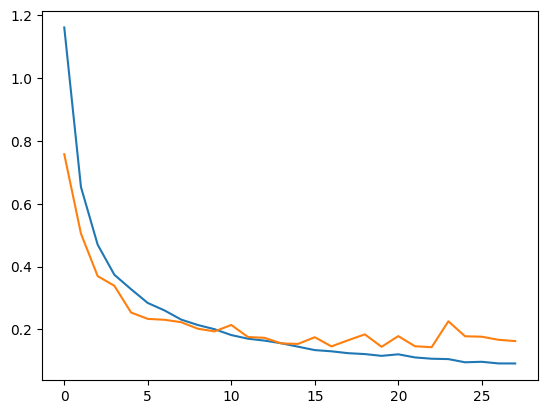

In [28]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.show()